<a href="https://colab.research.google.com/github/Jtrep10/NTK_Experiments/blob/modifiable_script/NTK_empirical_generalized_adapted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Library Import

In [71]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [72]:
import os
os.makedirs("img",exist_ok=True) # create folder for images if it does not already exist

In [73]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


# Helper Functions

In [74]:
# Util funcs


def input(gamma:float)->torch.Tensor:
  gamma=torch.Tensor([gamma])
  x=torch.tensor([torch.cos(gamma),torch.sin(gamma)])
  return x

def flatten(ls):
  return [item for sublist in ls for item in sublist]


# Simple Mean Loss function

def mean_loss(inp):
    return torch.mean(inp)

# Loss Wrapper function, returns the loss and the gradient of loss wrt net output

class LossWrapper(nn.Module):
    def __init__(self, loss_function):
      super(LossWrapper, self).__init__()
      self.loss_function = loss_function

    def loss_with_costgrad(self, net_out):
        L = net_out.shape[0]
        ret_loss = self.loss_function(net_out)

        nout = net_out.clone().detach()
        nout.requires_grad_(True)
        loss_out = self.loss_function(nout)
        nout.retain_grad()
        loss_out.backward()

        return ret_loss, nout.grad


torch.use_deterministic_algorithms=True

# adding argument to allow different output dimension selections
def create_model(width, depth, seed, out_dim,activation:nn.Module,beta=0.1):
  torch.manual_seed(seed)
  random.seed(seed)
  def scale_weights(m):
    if isinstance(m,nn.Linear):
      width_l=m.out_features
      # m.weight.data.normal_(1/torch.sqrt(torch.tensor(width_l)))
      m.weight.data.normal_(1/width_l)
      m.bias.data.normal_(std=beta)
  # Append input layer with array of hidden layer and output layer
  mdl = nn.Sequential(
        *([nn.Linear(2, width), activation()] \
        + flatten([[nn.Linear(width, width), activation()] for k in range(depth - 2)]) \
        + [nn.Linear(width, out_dim)])
  )
  # mdl.apply(scale_weights)
  return mdl

def reset_grads(model):
   for name, param in model.named_parameters():
        if "weight" in name:
            param.grad = None

def get_cost_grads(model):
    dCost = []
    for name, param in model.named_parameters():
        if "weight" in name:
            dCost.append(param.grad.flatten())

    dCost = torch.concatenate(dCost)
    return dCost


def undo_first_in_chainrule(grad, dCdF, dev):
    dFunc = torch.stack([
        grad / torch.Tensor([dCdF[i]]).to(dev) for i in range(dCdF.shape[0])
    ])

    return dFunc.to(dev)

Very simple training function to see how the NTK looks before and after training.

In [75]:
def train_model(model, optimizer, loss_fn, desired_out,num_epochs, seed, device,gamma_spacing=0.01,print_loss=True):
  # desired_out should operate on gamma to generate a target output
  # loss function should be from torch.nn
  torch.manual_seed(seed)
  random.seed(seed)
  model=model.to(device)
  model.train()
  gamma_vec = torch.arange(-1*np.pi, np.pi, gamma_spacing)
  for epoch in range(num_epochs):
    for gamma in gamma_vec:
      x_in = input(gamma).to(device)
      out = model.forward(x_in)
      loss = loss_fn(out,desired_out(gamma).to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    if print_loss:
      print(f"Loss at the end of epoch {epoch}: {loss}")
  model.eval()
  return model

# NTK Calculation Functions

While running experiments, I found that the current NTK calculation produces a matrix for which each element is the same number. This means that the matrix is rank 1 and the condition number (max(eigenvalues)/min(eigenvalues)) is infinite.

I added an alternative implementation for which the NTKs are full rank (the elements are not the same number). In this implementation, I extract the gradients separately for each output by applying the identity loss of each output and concatenating the results. This also produces consistent results across multiple runs on the same random seed.

Experiments showing these observations are included below.

In [76]:
def get_NTK(model, loss_function, ref_input, input, device):

   lfn = LossWrapper(loss_function)

   out1 = model.forward(ref_input)
  #  lfn.loss_with_costgrad(out1)
   loss, g_loss = lfn.loss_with_costgrad(out1) # return loss and gradient of loss wrt function output

   loss.backward()
   cost_grads_1 = get_cost_grads(model) # dC/dtheta
   N1 = undo_first_in_chainrule(cost_grads_1, g_loss, device) # undoing first chainrule to get vector of dFunctionOutput/dTheta (actual NTK element)

   out2 = model.forward(input)
   loss2, g_loss2 = lfn.loss_with_costgrad(out2)

   loss2.backward()
   cost_grads_2 = get_cost_grads(model)
   N2 = undo_first_in_chainrule(cost_grads_2, g_loss2, device)

   # Made adjustment for 2d NTK
   NTK = torch.matmul(N1, torch.t(N2))
   reset_grads(model)
   return NTK


def doNTK(model, loss_function, device, gamma_spacing:float=0.01)->torch.Tensor:
  gammas = torch.arange(-1*np.pi, np.pi, gamma_spacing)

  NTK_arr = [
     get_NTK(model, loss_function, input(0.0).to(device), input(gamma).to(device), device) for gamma in gammas
  ]

  return gammas, NTK_arr

def doNTK_surface(model, loss_function, device, numpts)->torch.Tensor:
  X = np.linspace(-1, 1, numpts, dtype=np.float32)
  Y = np.linspace(-1, 1, numpts, dtype=np.float32)
  gX, gY = np.meshgrid(X, Y)

  gZ = [
     [get_NTK(model, loss_function, torch.tensor([1.0, 0.0]).to(device), torch.tensor([_X, _Y]).to(device), device)[0, 0].item() for _X in X] for _Y in Y
  ]


  return gX, gY, np.array(gZ)

def get_NTK_eigenvalues(model, loss_function, input_1, input_2, device, return_NTK=False):
  NTK = get_NTK(model,loss_function, input_1, input_2, device)
  lambdas,_ = torch.linalg.eig(NTK)
  lambdas = lambdas.abs()
  condition_number = torch.max(lambdas)/torch.min(lambdas)
  print(f"Condition number: {condition_number}")
  if not return_NTK:
    return lambdas.cpu().numpy()
  else:
    return lambdas.cpu().numpy(),NTK

Results with current implementation:

In [77]:
########################################### ADJUST HERE
ACTIVATION = nn.ReLU
WIDTHS = [100, 500, 1000, 1500]
DEPTH = 4
SEED = 32
LOSS = mean_loss
OUT_DIM=5
###########################################

for W in WIDTHS:
    mod = create_model(W,DEPTH,SEED,OUT_DIM,ACTIVATION).to(device)
    lambdas,NTK = get_NTK_eigenvalues(mod,mean_loss,input(gamma=0).to(device),input(gamma=1).to(device),device,return_NTK=True) # can change gammas for input
    print(NTK)

Condition number: inf
tensor([[17.8151, 17.8151, 17.8151, 17.8151, 17.8151],
        [17.8151, 17.8151, 17.8151, 17.8151, 17.8151],
        [17.8151, 17.8151, 17.8151, 17.8151, 17.8151],
        [17.8151, 17.8151, 17.8151, 17.8151, 17.8151],
        [17.8151, 17.8151, 17.8151, 17.8151, 17.8151]], device='cuda:0')
Condition number: inf
tensor([[61.0406, 61.0406, 61.0406, 61.0406, 61.0406],
        [61.0406, 61.0406, 61.0406, 61.0406, 61.0406],
        [61.0406, 61.0406, 61.0406, 61.0406, 61.0406],
        [61.0406, 61.0406, 61.0406, 61.0406, 61.0406],
        [61.0406, 61.0406, 61.0406, 61.0406, 61.0406]], device='cuda:0')
Condition number: inf
tensor([[116.1034, 116.1034, 116.1034, 116.1034, 116.1034],
        [116.1034, 116.1034, 116.1034, 116.1034, 116.1034],
        [116.1034, 116.1034, 116.1034, 116.1034, 116.1034],
        [116.1034, 116.1034, 116.1034, 116.1034, 116.1034],
        [116.1034, 116.1034, 116.1034, 116.1034, 116.1034]], device='cuda:0')
Condition number: inf
tensor([

Try an alternative implementation.

In [78]:
def get_grads(net):
  theta = [param.grad.flatten() for name,param in net.named_parameters()]
  theta = torch.concatenate(theta) # list to tensor
  return theta

def get_grad_multi_out(model,input):
  # apply identity loss to each output individually
  # output at each index produces one row in NTK
  loss_fn = nn.Identity() # get gradients wrt output
  out = model.forward(input)
  grads = []
  for i in range(len(out)): # get gradients separately for each element of output
    out=model.forward(input)
    o=out[i]
    loss=loss_fn(o)
    loss.backward()
    grads.append(get_grads(model))
    model.zero_grad() # make sure backpropagation does not occur
    del loss # ensure no interference across iterations
  grads = torch.stack(grads) # list of 1d tensors to single 2d tensor
  return grads


def get_NTK_alt(model,ref_input:torch.Tensor,input:torch.Tensor,device)->torch.Tensor:
  model=model.to(device)
  dtheta1=get_grad_multi_out(model,ref_input.to(device))
  dtheta2=get_grad_multi_out(model,input.to(device))

  NKT=torch.inner(dtheta1,dtheta2)
  return NKT


def doNTK_alt(model, loss_function, device, gamma_spacing:float=0.01)->torch.Tensor:
  gammas = torch.arange(-1*np.pi, np.pi, gamma_spacing)

  NTK_arr = [
     get_NTK_alt(model, input(0.0).to(device), input(gamma).to(device), device) for gamma in gammas
  ]

  return gammas, NTK_arr

def doNTK_surface_alt(model, device, numpts)->torch.Tensor:
  X = np.linspace(-1, 1, numpts, dtype=np.float32)
  Y = np.linspace(-1, 1, numpts, dtype=np.float32)
  gX, gY = np.meshgrid(X, Y)

  gZ = [
     [get_NTK_alt(model, torch.tensor([1.0, 0.0]).to(device), torch.tensor([_X, _Y]).to(device), device)[0, 0].item() for _X in X] for _Y in Y
  ]


  return gX, gY, np.array(gZ)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

def get_NTK_eigenvalues_alt(model, input_1, input_2, device, return_NTK=False):
  NTK = get_NTK_alt(model, input_1, input_2, device)
  lambdas,_ = torch.linalg.eig(NTK)
  lambdas = lambdas.abs()
  condition_number = torch.max(lambdas)/torch.min(lambdas)
  print(f"Condition number: {condition_number}")
  if not return_NTK:
    return lambdas.cpu().numpy()
  else:
    return lambdas.cpu().numpy(),NTK


Using GPU: Tesla T4


The alternative implementation allows us to find NTKs with different values for each element. Also, the matrix has a finite condition number.

In [79]:
########################################### ADJUST HERE
ACTIVATION = nn.ReLU
WIDTHS = [100, 500, 1000, 1500]
DEPTH = 4
SEED = 32
LOSS = mean_loss
SURFACE_POINTS = 50
OUT_DIM_EIG=5
###########################################

for W in WIDTHS:
    mod = create_model(W,DEPTH,SEED,OUT_DIM_EIG,ACTIVATION).to(device)
    lambdas,NTK = get_NTK_eigenvalues_alt(mod,input(gamma=0).to(device),input(gamma=1).to(device),device,return_NTK=True) # can change gammas for input
    print(NTK)

Condition number: 1.3190470933914185
tensor([[ 2.6297,  0.0738,  0.1754,  0.0688,  0.0321],
        [ 0.0539,  2.4241, -0.1068,  0.1049,  0.0777],
        [ 0.2023, -0.1111,  2.6078, -0.1314, -0.2243],
        [ 0.0978,  0.1275, -0.1110,  2.5715, -0.0141],
        [ 0.0802,  0.1352, -0.1952, -0.0399,  2.4006]], device='cuda:0')
Condition number: 1.3032777309417725
tensor([[ 5.6938,  0.3050,  0.1837, -0.1893, -0.3843],
        [ 0.2178,  5.8555, -0.0810,  0.0426, -0.0434],
        [ 0.0114, -0.0706,  6.1820,  0.2612, -0.4513],
        [-0.1005,  0.1911,  0.3831,  5.7761, -0.0816],
        [-0.4032, -0.0374, -0.4897, -0.0587,  5.4409]], device='cuda:0')
Condition number: 1.163954496383667
tensor([[10.5983, -0.1319, -0.3782,  0.0133,  0.2381],
        [ 0.1415, 10.9311, -0.3594, -0.4342, -0.1805],
        [-0.0645, -0.1928, 11.3912, -0.2993, -0.5138],
        [-0.0932, -0.2202, -0.3844, 11.0003,  0.1254],
        [ 0.4043, -0.1872, -0.3482, -0.0947, 10.3774]], device='cuda:0')
Condition n

# Experiment Cell Templates

I have considered 4 experiment setups:

*   **NTK Surface**: Using a network with an input dimension of 2 and an output dimension of 1, calculate the NTK across inputs ranging -1 to 1 and use a 3d surface plot to show results.
*   **NTK 2D Plot Varying Seed**: Using a network with an input dimension of 2 and an output dimension of 1, parameterize the inputs with $\gamma$ as $[cos(\gamma),sin(\gamma)]^T$. This allows a 2d plot of $\gamma$ against the NTK. For this experiment, I plot multiple random seeds on top of each other with the same color to show variation across seed.
*  **Eigenvalue Histogram**: This allows NTK visualization with an arbitrary output dimension. Calculate the NTK for a specified output dimension and then calculate its eigenvalues. Pool eigenvalues across a list of seeds and show the histogram. (We could also choose to use only one seed here.) As a single number to characterize the matrix, I display the condition number, or $\kappa=\lambda_{max}/\lambda_{min}$.
*  **Before and After Training**: Initialize a model, show the NTK, train the model, and then show NTK after training. Currently I am using a 2d output and showing condition number and the NTK itself before and after training, but this can be changed.

For the first two experiments, I set the output dimension to 1 so that the NTK is scalar and no points are discarded when plotting. The third experiment allows visualization of high-dimensional NTKs.

Templates for each experiment are included below (commented).


In [80]:
# # Surface plots
# ########################################### ADJUST HERE
# ACTIVATION = nn.ReLU
# WIDTHS = [100, 500, 1000, 1500]
# DEPTH = 4
# SEED = 32
# SURFACE_POINTS = 50
# ###########################################

# for W in WIDTHS:
#     mod = create_model(W, DEPTH, SEED, 1, ACTIVATION).to(device) # use output_dim=1 for surface plots
#     X, Y, Z = doNTK_surface_alt(mod, device, SURFACE_POINTS)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(X, Y, Z, cmap='viridis')
#     s = "img/width_"+str(W)+"_Act_"+ACTIVATION.__name__
#     plt.savefig(s+"_surface.png")
#     plt.show()
#     plt.clf()

In [81]:
# # NTK 2D Plot Varying Seed
# ########################################### ADJUST HERE
# ACTIVATION = nn.ReLU
# WIDTHS = [100,500]
# WIDTH_COLORS=['b','g','y','c'] # list of colors to show different widths on the same plot, need len(colors)>=len(widths)
# DEPTH = 4
# SEED_LIST = [10,32,0]
# SURFACE_POINTS = 50
# ###########################################

# for i in range(len(WIDTHS)):
#   W = WIDTHS[i]
#   color=WIDTH_COLORS[i]
#   for seed in SEED_LIST:
#     model = create_model(W, DEPTH, seed, 1, ACTIVATION).to(device) # use output_dim=1 for surface plots
#     gap = 2.0 / SURFACE_POINTS
#     X, Y = doNTK_alt(model, device, gap)
#     bY = [Y[n].item() for n in range(len(Y))]
#     if seed==SEED_LIST[0]:
#       plt.plot(X, bY,label=f"Width={W}",color=color)
#     else:
#       plt.plot(X, bY,color=color)

# s=f"img/{str(ACTIVATION.__name__)}_2d_plot"
# plt.xlabel("gamma")
# plt.ylabel("NTK")
# plt.legend()
# plt.savefig(s+".png")
# print("Saved with width "+str(W))
# plt.show()
# plt.clf()


In [82]:
# # Eigenvalue Histogram
# ########################################### ADJUST HERE
# ACTIVATION = nn.ReLU
# WIDTHS = [100, 500, 1000, 2000]
# DEPTH = 4
# SEED_LIST = [32,43,50,0,32]
# SURFACE_POINTS = 50
# OUT_DIM_EIG=20
# ###########################################

# for W in WIDTHS:
#   lambdas_W=[]
#   print(f"Starting width={W}")
#   for SEED in SEED_LIST:
#     mod = create_model(W,DEPTH,SEED,OUT_DIM_EIG,ACTIVATION).to(device)
#     lambdas = get_NTK_eigenvalues_alt(mod,input(gamma=0).to(device),input(gamma=1).to(device),device) # can change gammas for input
#     lambdas_W.append(lambdas)
#   s = "img/Act_"+ACTIVATION.__name__
#   plt.hist(lambdas,label=f"Width={W}")
#   plt.title(f"Depth={DEPTH}, Output dimension={OUT_DIM_EIG}")
#   plt.legend()
#   plt.savefig(s+"_eigen.png")



In [83]:
# # Before and after training
# #############
# # Change parameters here
# seeds = [10, 32, 43, 56]
# num_epochs=10
# activation=nn.ReLU
# width=100
# depth=4
# out_dim=2
# learning_rate=1e-5 # loss does not decrease when I set this too high
# weight_decay=0
# desired_out = lambda gamma: torch.tensor([torch.cos(gamma)*torch.sin(gamma), # Using (x_1*x_2,(x_1*x_2)^2) as a simple example, can be changed
#                                           torch.square(torch.cos(gamma)*torch.sin(gamma))])
# loss = nn.MSELoss(reduction='mean')
# ###############

# for seed in seeds:
#   print(f"Using seed: {seed}")
#   model = create_model(width, depth, seed,out_dim, activation)
#   optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # can try with weight decay later
#   lambdas,NTK = get_NTK_eigenvalues_alt(model,input(0),input(1),device,return_NTK=True)
#   print(f"NTK before training: {NTK}")
#   model = train_model(model,optimizer,loss,desired_out,10,seed,device,print_loss=False)
#   lambdas,NTK = get_NTK_eigenvalues_alt(model,input(0),input(1),device,return_NTK=True)
#   print(f"NTK after training: {NTK}")

# Experiment Results

NTK surface experiments:

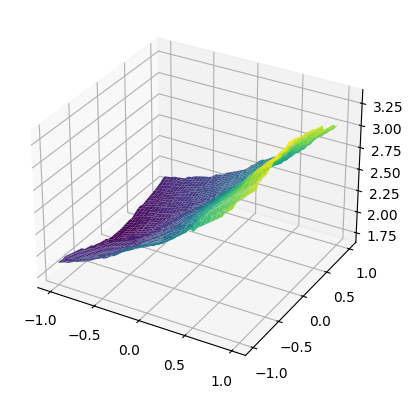

<Figure size 640x480 with 0 Axes>

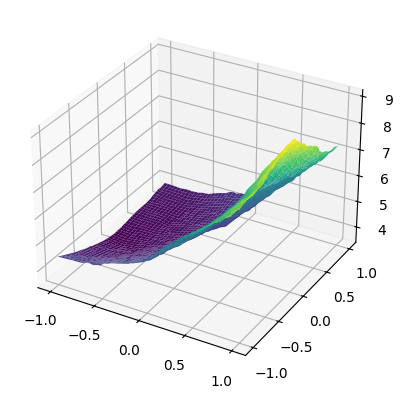

<Figure size 640x480 with 0 Axes>

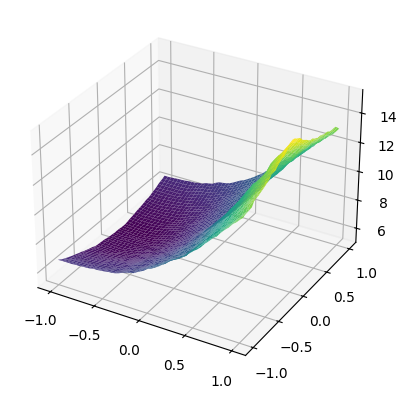

<Figure size 640x480 with 0 Axes>

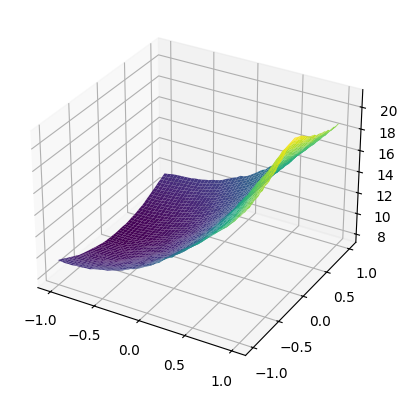

<Figure size 640x480 with 0 Axes>

In [84]:
# Surface plots
########################################### ADJUST HERE
ACTIVATION = nn.ReLU
WIDTHS = [100, 500, 1000, 1500]
DEPTH = 4
SEED = 32
SURFACE_POINTS = 50
###########################################

for W in WIDTHS:
    mod = create_model(W, DEPTH, SEED, 1, ACTIVATION).to(device) # use output_dim=1 for surface plots
    X, Y, Z = doNTK_surface_alt(mod, device, SURFACE_POINTS)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    s = "img/width_"+str(W)+"_Act_"+ACTIVATION.__name__
    plt.savefig(s+"_surface.png")
    plt.show()
    plt.clf()

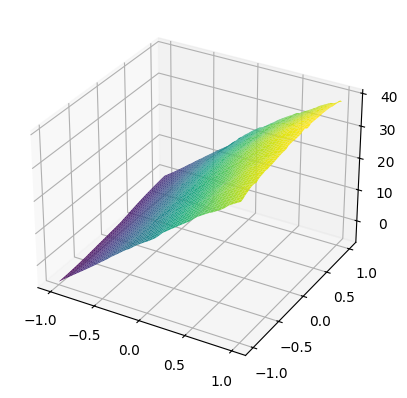

<Figure size 640x480 with 0 Axes>

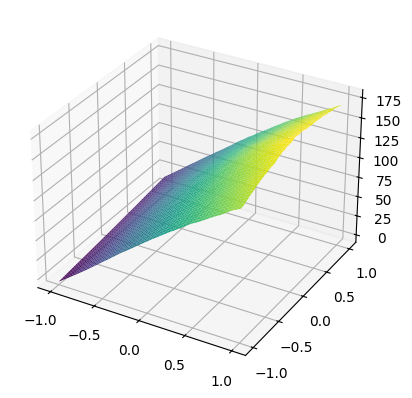

<Figure size 640x480 with 0 Axes>

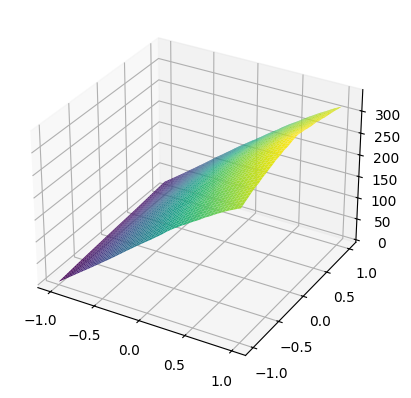

<Figure size 640x480 with 0 Axes>

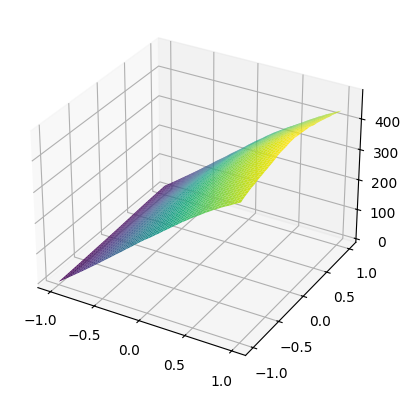

<Figure size 640x480 with 0 Axes>

In [85]:
# Surface plots
########################################### ADJUST HERE
ACTIVATION = nn.SELU
WIDTHS = [100, 500, 1000, 1500]
DEPTH = 4
SEED = 32
SURFACE_POINTS = 50
###########################################

for W in WIDTHS:
    mod = create_model(W, DEPTH, SEED, 1, ACTIVATION).to(device) # use output_dim=1 for surface plots
    X, Y, Z = doNTK_surface_alt(mod, device, SURFACE_POINTS)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    s = "img/width_"+str(W)+"_Act_"+ACTIVATION.__name__
    plt.savefig(s+"_surface.png")
    plt.show()
    plt.clf()

NTK 2D Plot Varying Seed experiments:

Saved with width 1000


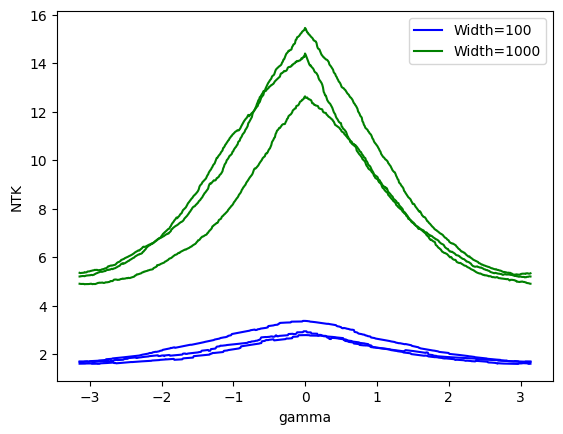

<Figure size 640x480 with 0 Axes>

In [86]:
# NTK 2D Plot Varying Seed
########################################### ADJUST HERE
ACTIVATION = nn.ReLU
WIDTHS = [100,1000]
WIDTH_COLORS=['b','g','y','c'] # list of colors to show different widths on the same plot, need len(colors)>=len(widths)
DEPTH = 4
SEED_LIST = [10,32,0]
SURFACE_POINTS = 50
###########################################

for i in range(len(WIDTHS)):
  W = WIDTHS[i]
  color=WIDTH_COLORS[i]
  for seed in SEED_LIST:
    model = create_model(W, DEPTH, seed, 1, ACTIVATION).to(device) # use output_dim=1 for surface plots
    gap = 2.0 / SURFACE_POINTS
    X, Y = doNTK_alt(model, device, gap)
    bY = [Y[n].item() for n in range(len(Y))]
    if seed==SEED_LIST[0]:
      plt.plot(X, bY,label=f"Width={W}",color=color)
    else:
      plt.plot(X, bY,color=color)

s=f"img/{str(ACTIVATION.__name__)}_2d_plot"
plt.xlabel("gamma")
plt.ylabel("NTK")
plt.legend()
plt.savefig(s+".png")
print("Saved with width "+str(W))
plt.show()
plt.clf()


Saved with width 1000


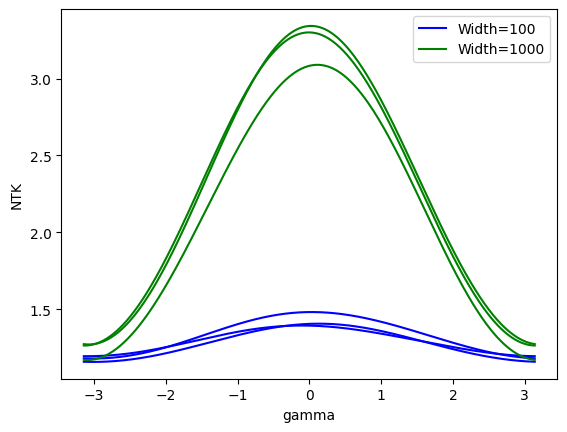

<Figure size 640x480 with 0 Axes>

In [87]:
# NTK 2D Plot Varying Seed
########################################### ADJUST HERE
ACTIVATION = nn.SiLU
WIDTHS = [100,1000]
WIDTH_COLORS=['b','g','y','c'] # list of colors to show different widths on the same plot, need len(colors)>=len(widths)
DEPTH = 4
SEED_LIST = [10,32,0]
SURFACE_POINTS = 50
###########################################

for i in range(len(WIDTHS)):
  W = WIDTHS[i]
  color=WIDTH_COLORS[i]
  for seed in SEED_LIST:
    model = create_model(W, DEPTH, seed, 1, ACTIVATION).to(device) # use output_dim=1 for surface plots
    gap = 2.0 / SURFACE_POINTS
    X, Y = doNTK_alt(model, device, gap)
    bY = [Y[n].item() for n in range(len(Y))]
    if seed==SEED_LIST[0]:
      plt.plot(X, bY,label=f"Width={W}",color=color)
    else:
      plt.plot(X, bY,color=color)

s=f"img/{str(ACTIVATION.__name__)}_2d_plot"
plt.xlabel("gamma")
plt.ylabel("NTK")
plt.legend()
plt.savefig(s+".png")
print("Saved with width "+str(W))
plt.show()
plt.clf()


Eigenvalue histograms:

Starting width=100
Condition number: 2.1370294094085693
Condition number: 2.2245075702667236
Condition number: 2.2607181072235107
Condition number: 2.0132384300231934
Starting width=500
Condition number: 1.7510110139846802
Condition number: 1.819963812828064
Condition number: 1.7252850532531738
Condition number: 1.7205090522766113
Starting width=1000
Condition number: 1.5772950649261475
Condition number: 1.47034752368927
Condition number: 1.5849603414535522
Condition number: 1.5846625566482544
Starting width=2000
Condition number: 1.4383291006088257
Condition number: 1.3885992765426636
Condition number: 1.4519339799880981
Condition number: 1.4638820886611938


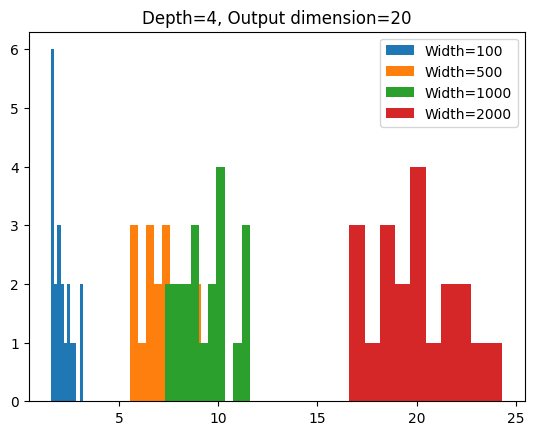

In [88]:
# Eigenvalue Histogram
########################################### ADJUST HERE
ACTIVATION = nn.ReLU
WIDTHS = [100, 500, 1000, 2000]
DEPTH = 4
SEED_LIST = [32,43,50,0]
SURFACE_POINTS = 50
OUT_DIM_EIG=20
###########################################

for W in WIDTHS:
  lambdas_W=[]
  print(f"Starting width={W}")
  for SEED in SEED_LIST:
    mod = create_model(W,DEPTH,SEED,OUT_DIM_EIG,ACTIVATION).to(device)
    lambdas = get_NTK_eigenvalues_alt(mod,input(gamma=0).to(device),input(gamma=1).to(device),device) # can change gammas for input
    lambdas_W.append(lambdas)
  s = "img/Act_"+ACTIVATION.__name__
  plt.hist(lambdas,label=f"Width={W}")
  plt.title(f"Depth={DEPTH}, Output dimension={OUT_DIM_EIG}")
  plt.legend()
  plt.savefig(s+"_eigen.png")



Starting width=100
Condition number: 1.3274790048599243
Condition number: 1.2683935165405273
Condition number: 1.3070790767669678
Condition number: 1.2370089292526245
Starting width=500
Condition number: 1.3119332790374756
Condition number: 1.2841708660125732
Condition number: 1.2677319049835205
Condition number: 1.264316439628601
Starting width=1000
Condition number: 1.2816352844238281
Condition number: 1.2555818557739258
Condition number: 1.2708559036254883
Condition number: 1.2476086616516113
Starting width=2000
Condition number: 1.227036476135254
Condition number: 1.2166532278060913
Condition number: 1.2621716260910034
Condition number: 1.2317187786102295


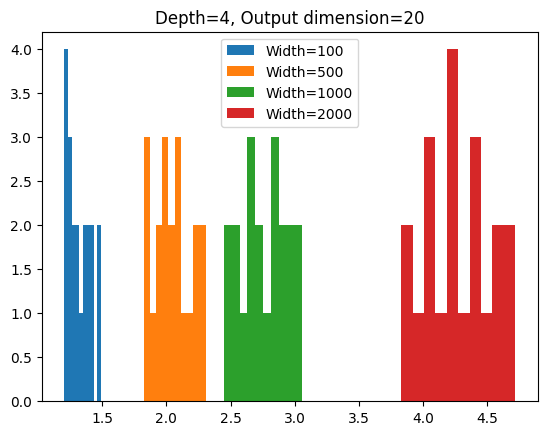

In [89]:
# Eigenvalue Histogram
########################################### ADJUST HERE
ACTIVATION = nn.SiLU
WIDTHS = [100, 500, 1000, 2000]
DEPTH = 4
SEED_LIST = [32,43,50,0]
SURFACE_POINTS = 50
OUT_DIM_EIG=20
###########################################

for W in WIDTHS:
  lambdas_W=[]
  print(f"Starting width={W}")
  for SEED in SEED_LIST:
    mod = create_model(W,DEPTH,SEED,OUT_DIM_EIG,ACTIVATION).to(device)
    lambdas = get_NTK_eigenvalues_alt(mod,input(gamma=0).to(device),input(gamma=1).to(device),device) # can change gammas for input
    lambdas_W.append(lambdas)
  s = "img/Act_"+ACTIVATION.__name__
  plt.hist(lambdas,label=f"Width={W}")
  plt.title(f"Depth={DEPTH}, Output dimension={OUT_DIM_EIG}")
  plt.legend()
  plt.savefig(s+"_eigen.png")



In [90]:
# Before and after training
#############
# Change parameters here
seeds = [10, 32, 43, 56]
num_epochs=10
activation=nn.ReLU
width=100
depth=4
out_dim=2
learning_rate=1e-5 # loss does not decrease when I set this too high
weight_decay=0
desired_out = lambda gamma: torch.tensor([torch.cos(gamma)*torch.sin(gamma), # Using (x_1*x_2,(x_1*x_2)^2) as a simple example, can be changed
                                          torch.square(torch.cos(gamma)*torch.sin(gamma))])
loss = nn.MSELoss(reduction='mean')
###############

for seed in seeds:
  print(f"Using seed: {seed}")
  model = create_model(width, depth, seed,out_dim, activation)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # can try with weight decay later
  lambdas,NTK = get_NTK_eigenvalues_alt(model,input(0),input(1),device,return_NTK=True)
  print(f"NTK before training: {NTK}")
  model = train_model(model,optimizer,loss,desired_out,10,seed,device,print_loss=False)
  lambdas,NTK = get_NTK_eigenvalues_alt(model,input(0),input(1),device,return_NTK=True)
  print(f"NTK after training: {NTK}")

Using seed: 10
Condition number: 1.195746898651123
NTK before training: tensor([[ 2.2634, -0.1847],
        [-0.2220,  2.2877]], device='cuda:0')
Condition number: 1.028283715248108
NTK after training: tensor([[ 2.2123,  0.0084],
        [-0.1557,  2.3084]], device='cuda:0')
Using seed: 32
Condition number: 1.1002533435821533
NTK before training: tensor([[2.6297, 0.0738],
        [0.0539, 2.4241]], device='cuda:0')
Condition number: 1.0749057531356812
NTK after training: tensor([[2.6041, 0.0286],
        [0.0651, 2.4435]], device='cuda:0')
Using seed: 43
Condition number: 1.055884838104248
NTK before training: tensor([[ 2.2604,  0.0161],
        [-0.0212,  2.1353]], device='cuda:0')
Condition number: 1.0208160877227783
NTK after training: tensor([[ 2.2388,  0.1127],
        [-0.0205,  2.1326]], device='cuda:0')
Using seed: 56
Condition number: 1.0551291704177856
NTK before training: tensor([[ 1.9776, -0.0341],
        [-0.0701,  2.0217]], device='cuda:0')
Condition number: 1.0673402547

In [91]:
# Before and after training
#############
# Change parameters here
seeds = [10, 32, 43, 56]
num_epochs=10
activation=nn.ReLU
width=100
depth=4
out_dim=2
learning_rate=1e-5 # loss does not decrease when I set this too high
weight_decay=0.1
desired_out = lambda gamma: torch.tensor([torch.cos(gamma)*torch.sin(gamma), # Using (x_1*x_2,(x_1*x_2)^2) as a simple example, can be changed
                                          torch.square(torch.cos(gamma)*torch.sin(gamma))])
loss = nn.MSELoss(reduction='mean')
###############

for seed in seeds:
  print(f"Using seed: {seed}")
  model = create_model(width, depth, seed,out_dim, activation)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # can try with weight decay later
  lambdas,NTK = get_NTK_eigenvalues_alt(model,input(0),input(1),device,return_NTK=True)
  print(f"NTK before training: {NTK}")
  model = train_model(model,optimizer,loss,desired_out,10,seed,device,print_loss=False)
  lambdas,NTK = get_NTK_eigenvalues_alt(model,input(0),input(1),device,return_NTK=True)
  print(f"NTK after training: {NTK}")

Using seed: 10
Condition number: 1.195746898651123
NTK before training: tensor([[ 2.2634, -0.1847],
        [-0.2220,  2.2877]], device='cuda:0')
Condition number: 1.0105924606323242
NTK after training: tensor([[ 2.1726,  0.0131],
        [-0.1503,  2.2642]], device='cuda:0')
Using seed: 32
Condition number: 1.1002533435821533
NTK before training: tensor([[2.6297, 0.0738],
        [0.0539, 2.4241]], device='cuda:0')
Condition number: 1.0729273557662964
NTK after training: tensor([[2.5538, 0.0269],
        [0.0630, 2.4002]], device='cuda:0')
Using seed: 43
Condition number: 1.055884838104248
NTK before training: tensor([[ 2.2604,  0.0161],
        [-0.0212,  2.1353]], device='cuda:0')
Condition number: 1.0215694904327393
NTK after training: tensor([[ 2.2032,  0.1111],
        [-0.0196,  2.0991]], device='cuda:0')
Using seed: 56
Condition number: 1.0551291704177856
NTK before training: tensor([[ 1.9776, -0.0341],
        [-0.0701,  2.0217]], device='cuda:0')
Condition number: 1.067524433